# Comparing models

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

Keras

In [11]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

## Pickle handler

In [3]:
class DataSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Load data

In [4]:
data = DataSaver('data/preprocessed').load()
path = '../training-data-preprocessed/'
dataOld = DataSaver(path + 'data3').load()

In [45]:
training = data['train']
testing = data['test']
validation = data['validation']

xTrain = training['x']
yTrainPlain = training['y']
yTrain = to_categorical(yTrainPlain, num_classes=43)

xTest = testing['x']
yTestPlain = testing['y']
yTest = to_categorical(yTestPlain, num_classes=43)

xValid = validation['x']
yValidPlain = validation['y']
yValid = to_categorical(yValidPlain, num_classes=43)

labels = data['labels']

In [54]:
xTrainOld = dataOld['x_train'].transpose(0, 2, 3, 1)
yTrainOld = to_categorical(dataOld['y_train'], num_classes=43)
yTrainOldPlain = dataOld['y_train']

xTestOld = dataOld['x_test'].transpose(0, 2, 3, 1)
yTestOld = to_categorical(dataOld['y_test'], num_classes=43)
yTestOldPlain = dataOld['y_test']

xValidOld = dataOld['x_validation'].transpose(0, 2, 3, 1)
yValidOld = to_categorical(dataOld['y_validation'], num_classes=43)
yValidOldPlain = dataOld['y_validation']

## Load models

Model1: Basic model trained on the old dataset

In [12]:
model1 = load_model('models/model1.h5')

Model2: Basic model trained on my dataset

In [13]:
model2 = load_model('models/model2.h5')

Model3: Basic model with a right validation dataset and harder dropout

In [14]:
model3= load_model('models/model3.h5')

Model4: Basic model with weaker dropout

In [15]:
model4= load_model('models/model4.h5')

In [19]:
models = (model1, model2, model3, model4)

## Test functions

In [233]:
def showImage(img, size=4):
    low, high = np.min(img), np.max(img)
    img = (img - low) / (high - low)
    plt.figure(figsize = (size, size))
    plt.imshow(img, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
def getPrediction(model, index):
    return np.argmax(model.predict(np.array([xTest[index]])))

def showPrediction(model, index):
    prediction = model.predict(np.array([xTest[index]]))[0]
    predictions = np.argsort(prediction)[::-1]
    print('Prediction: ', labels[predictions[0]])
    print('Actual: ', labels[data['test']['y'][index]])
    if (predictions[0] != data['test']['y'][index]):
        print('Correct guess was no.', np.where(predictions == data['test']['y'][index])[0][0] + 1)
        prediction = -np.sort(-prediction)
        print(prediction[0], prediction[1])
    showImage(xTest[index])
    
def showEvaluation(model, x, y):
    score = model.evaluate(x, y, verbose=0)
    print('Test accuracy: ', score[1])
    
def showMissedImages(model, x, y):
    topGuesses = np.argsort(model.predict(x), axis=1)[:, ::-1][:, :1]
    success = [ int(y[i] in topGuesses[i]) for i in range(0, len(x)) ]
    success = np.array(success)
    badImages = x[success == 0]
    for img in badImages:
        showImage(img)

def showKernels(model1):
    kernels = np.array([np.array(model1.layers[0].kernel[0]), np.array(model1.layers[0].kernel[1]), np.array(model1.layers[0].kernel[2])])
    kernels = kernels.transpose(3, 2, 1, 0)
    for kernel in kernels:
        showImage(kernel, 1)
        
def countMissedImages(model, x, y):
    predictions = model.predict(x)
    classifications = np.argmax(predictions, axis=1)
    missed = y[np.arange(len(classifications))[classifications != y]]
    return np.bincount(missed, minlength=43)
    
def showDistributionOfMissedImages(model, x, y):
    missed = countMissedImages(model, x, y)
    fig, ax = plt.subplots(figsize=(14,5))
    distribution = missed / np.bincount(y)
    ax.bar(labels, distribution)    
    ax.set_xticklabels(labels, rotation=60, ha='right')
    ax.axhline(distribution.mean(), color='blue', linewidth=2)
    plt.show()

## Comparing models

Evaluating test results:

In [21]:
showEvaluation(model1, xTestOld, yTestOld)
showEvaluation(model2, xTest, yTest)
showEvaluation(model3, xTest, yTest)
showEvaluation(model4, xTest, yTest)

Test accuracy:  0.8740301132202148
Test accuracy:  0.8946951627731323
Test accuracy:  0.8840063214302063
Test accuracy:  0.8998416662216187


Evaluating overfitting

In [22]:
showEvaluation(model1, xTrainOld[:10000], yTrainOld[:10000])
showEvaluation(model2, xTrain[:10000], yTrain[:10000])
showEvaluation(model3, xTrain[:10000], yTrain[:10000])
showEvaluation(model4, xTrain[:10000], yTrain[:10000])

Test accuracy:  0.9785000085830688
Test accuracy:  0.9976000189781189
Test accuracy:  0.9955999851226807
Test accuracy:  0.9975000023841858


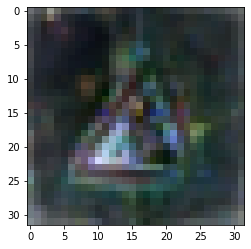

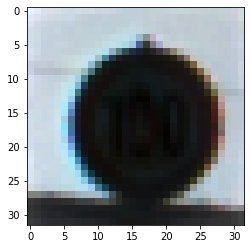

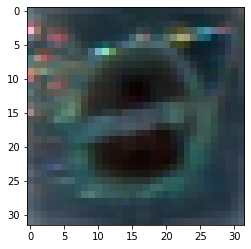

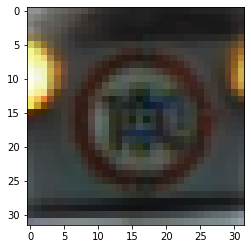

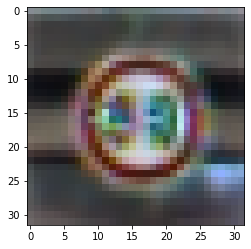

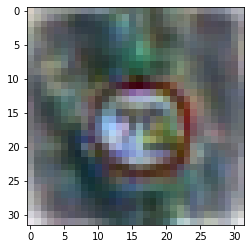

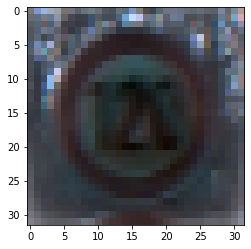

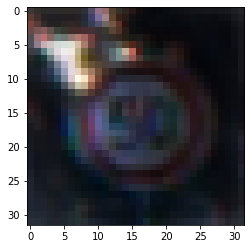

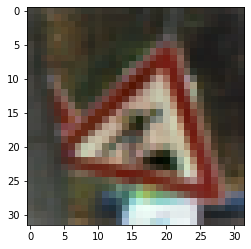

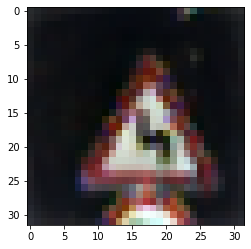

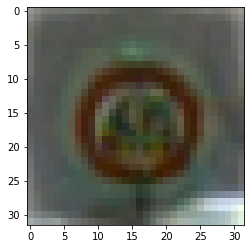

In [111]:
showMissedImages(model1, xTestOld[:100], yTestOldPlain[:100])

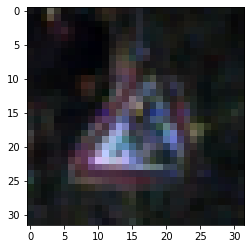

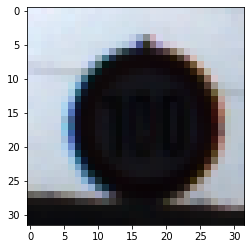

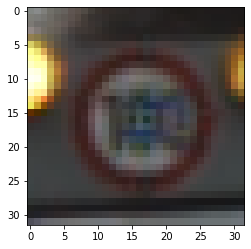

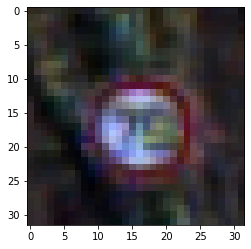

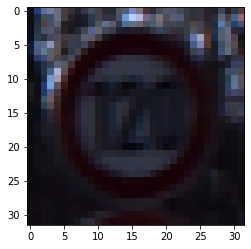

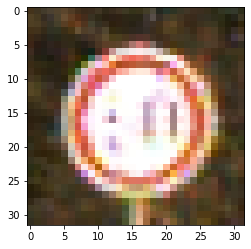

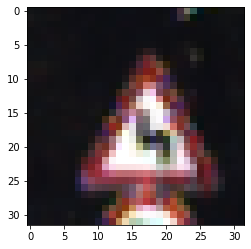

In [60]:
showMissedImages(model2, xTest[:100], yTestPlain[:100])

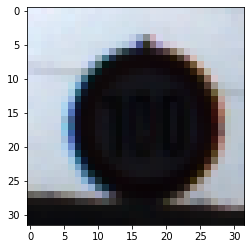

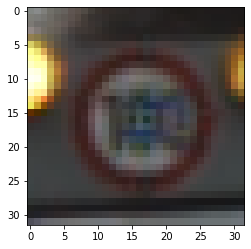

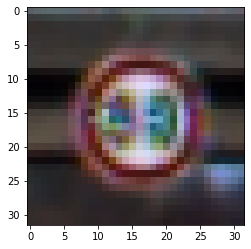

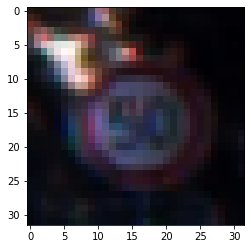

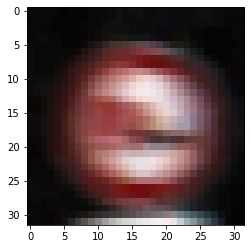

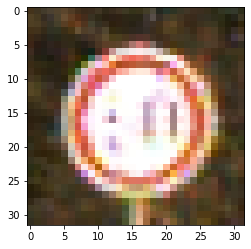

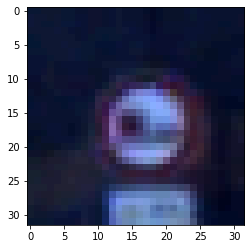

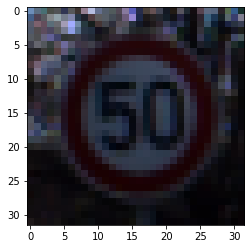

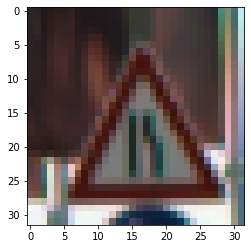

In [61]:
showMissedImages(model3, xTest[:100], yTestPlain[:100])

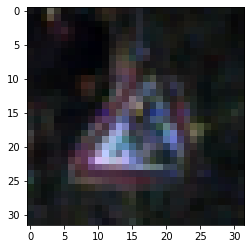

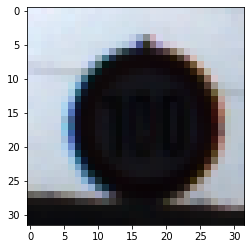

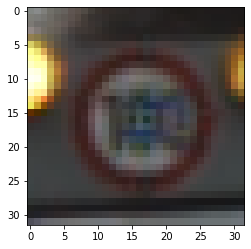

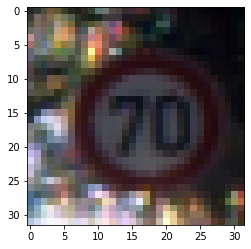

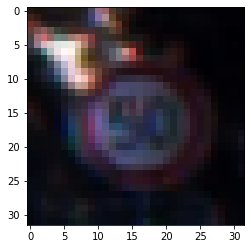

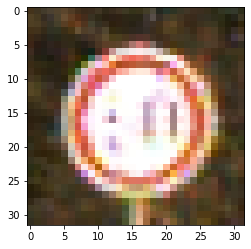

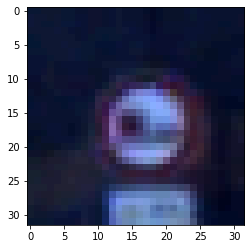

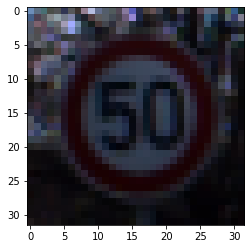

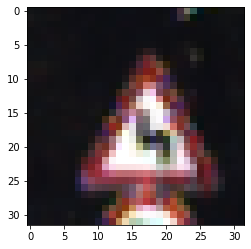

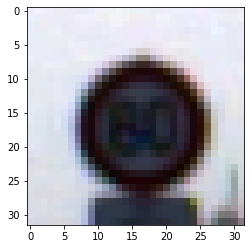

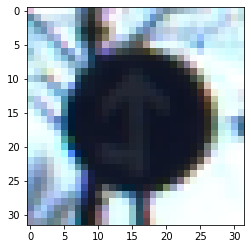

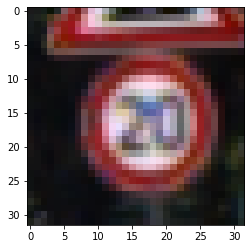

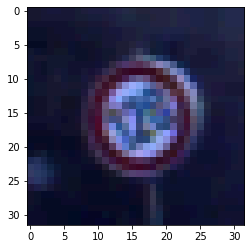

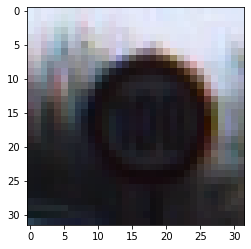

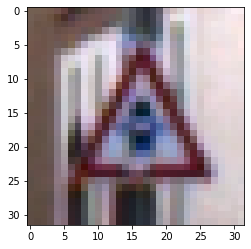

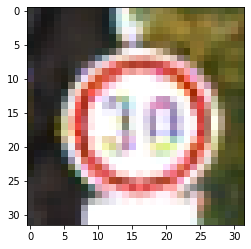

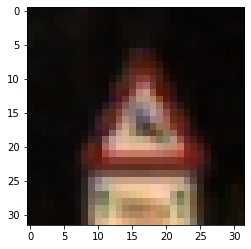

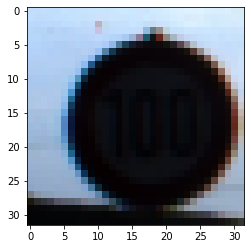

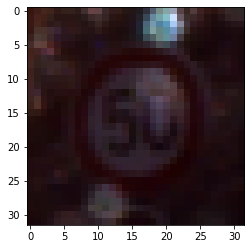

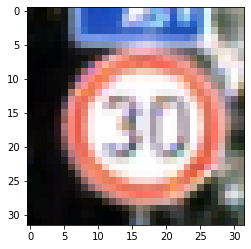

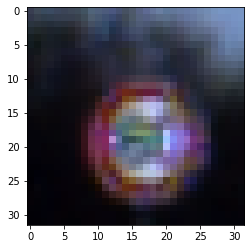

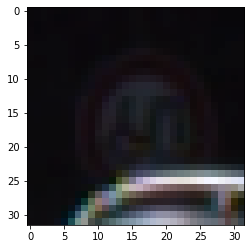

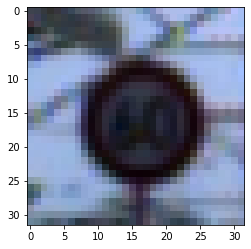

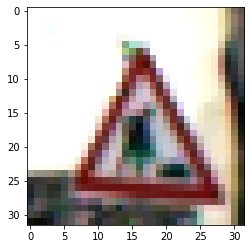

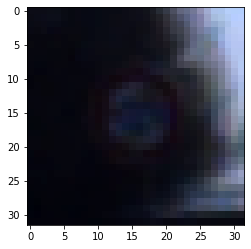

In [114]:
showMissedImages(model4, xTest[:300], yTestPlain[:300])

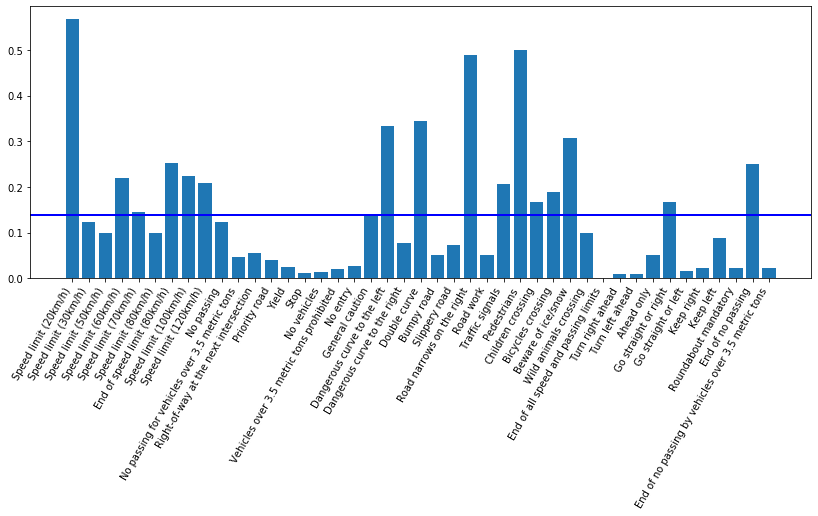

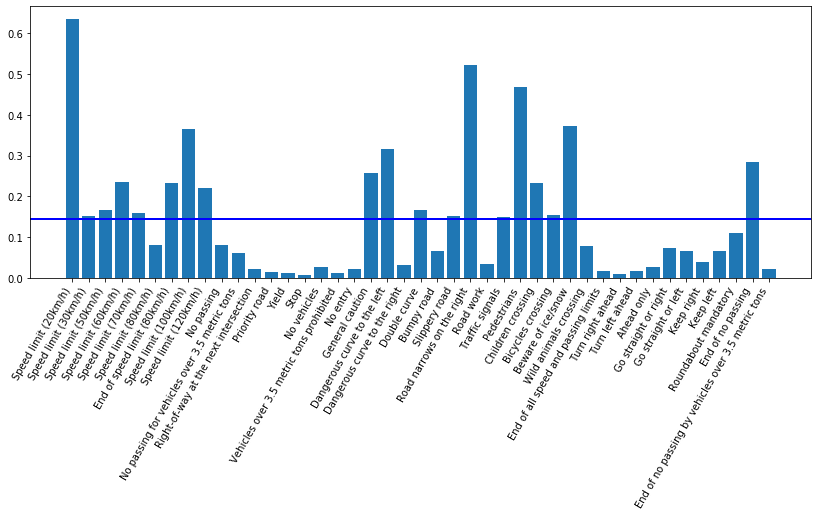

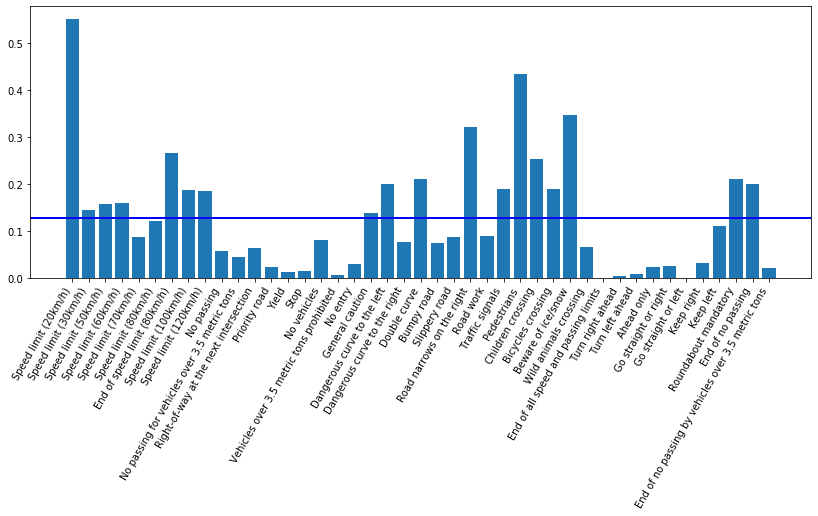

In [234]:
showDistributionOfMissedImages(model2, xTest, yTestPlain)
showDistributionOfMissedImages(model3, xTest, yTestPlain)
showDistributionOfMissedImages(model4, xTest, yTestPlain)

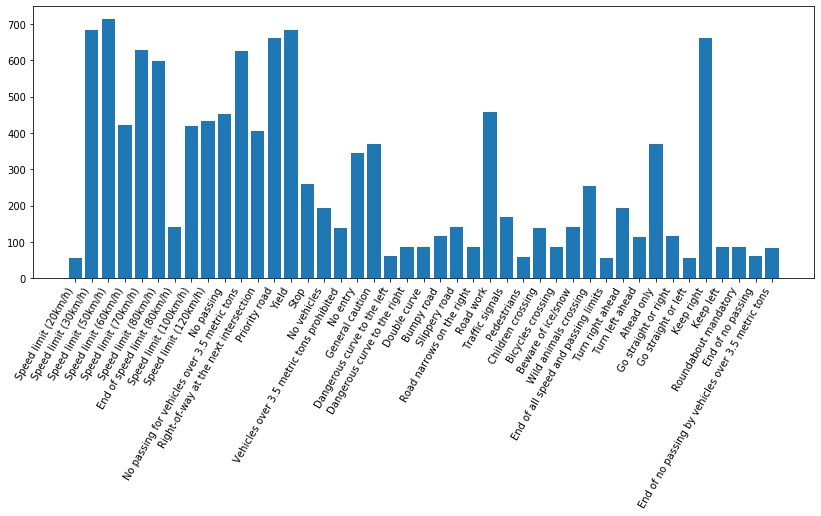

In [240]:
fig, ax = plt.subplots(figsize=(14,5))
ax.bar(labels, np.bincount(yTestPlain[:12000])) 
ax.set_xticklabels (labels, rotation=60, ha='right')
plt.show()